# Parallel Computing
---
### Coroutines
- Most usefull in unbalanced workloads. Dynamic scheduling with producer and consumer algorithms

### Multi-threading
- @thread macro
- Atomic operations -> avoid race condition

### Distributed Computing
- Code availability and loading packages  
- Data movement

### GPU
- CUDA and OpenCL support
- Hands off approach: use existing library such as CuArrays or CLArrays 
- Hands on approach: write custom GPU kernel using CUDAnative and CUDAdrv

----
## Example: Bootstrapping

Topics: Random numbers, distributed computing, multithreading

In [1]:
using Statistics, CSV, Plots, DataFrames, GLM

In [2]:
agrenURL = "https://bitbucket.org/linen/smalldata/raw/3c9bcd603b67a16d02c5dc23e7e3e637758d4d5f/arabidopsis/agren2013.csv"
agren = CSV.read(download(agrenURL),missingstring="NA");

In [3]:
describe(agren)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Nothing,Union…,Type
1,it09,12.2106,6.28846,12.0582,20.5921,,6,"Union{Missing, Float64}"
2,it10,8.08256,1.77401,7.53993,24.1761,,2,"Union{Missing, Float64}"
3,it11,8.92073,3.23889,8.52447,19.3107,,,Float64
4,sw09,10.8503,5.66443,10.832,15.0012,,6,"Union{Missing, Float64}"
5,sw10,23.3658,19.2318,23.0893,34.1327,,2,"Union{Missing, Float64}"
6,sw11,13.4934,4.47778,12.8102,32.1889,,,Float64
7,id,325.637,1,313.5,700,,,Int64
8,flc,1.535,1,2.0,2,,,Int64


In [ ]:
# Load random number package
using Random

# initialize random number generator
rng = MersenneTwister(1234321);

# set number of bootstrap sample
nboot = 100_000

# sample indices
idx = rand(rng,1:400,400,nboot);

# check size of index matrix
size(idx)

In [ ]:
# allocate memory for bootstrap results
estBoot = zeros(nboot)

# loop over number of bootstrap samples; time
@time for i=1:nboot
    estBoot[i] = median(agren[idx[:,i],3])
end

In [ ]:

# load packages
using Distributed, SharedArrays

# add processes, but no more than 3 (one head, two worker)
# or you can start julia with multiple process: $ julia -p 3
if( nprocs()< 3 ) 
    addprocs(3-nprocs())
end


# load packages we are going to use on each process
@everywhere using Statistics, DataFrames, CSV, GLM, SharedArrays

# create array shared by all processes
estBootPar = SharedArray(zeros(nboot));

# send random index matrix to all processes
@everywhere idx

# send agren dataset to all processes
@everywhere agren

In [15]:
nprocs()

3

In [ ]:
# bootstrap using distributed computing
@time @sync @distributed for i=1:nboot
    estBootPar[i] = median(agren[idx[:,i],3])
end

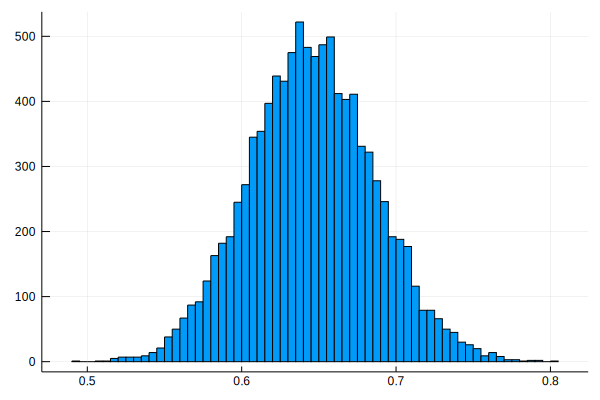

In [17]:
histogram(estBootPar[:,2],lab="")

### Multi-threading

To use multi-threading, one has to start Julia with multiple threads.  When using Jupyter, the easiest way to do this is to
install a kernel with the number of threads you will use.
```julia
    using IJulia
    installkernel("Julia (4 threads)", env=Dict("JULIA_NUM_THREADS"=>"4"))
```    
If you want to change the number of threads on the fly.  Use
```julia
    ENV["JULIA_NUM_THREADS"] = 4
    using IJulia
    notebook()
```

In [1]:
# check number of threads
Threads.nthreads()

# initialize array with bootstrapped estimates
estBootThr = zeros(nboot);

UndefVarError: UndefVarError: nboot not defined

The code to perform multithreading is almost identical to that for distributed processing, except for the macro that we invoke before the loop.

In [ ]:
@time Threads.@threads for i=1:nboot
    estBootThr[i,:] = median(agren[idx[:,i],3])
end

# GPU Computing

## Using GPU Packages
1. JuliaGPU github page lists all the GPU packages you can use for CUDA and OpenCL. 
2. CuArrays and CLArrays 
3. GPUArrays 

```julia
using CuArrays 

# Data Transfer 
a = rand(100,100)
b = rand(100,100)
d_a = CuArray(a)
d_b = CuArray(b)

# Multiple Dispatch
result = collect(d_a * d_b)

#explicit calling package function
result = collect(CuArrays.CUBLAS.gemm('N', 'N', d_a,d_b))
```



## Writing your own GPU code
1. Use CUDAnative and CUDAdrv 

```julia
# Data Transfer 

a = rand(100,100)
b = rand(100,100)
d_a = CuArray(a)
d_b = CuArray(b)

# Thread configuration
dev = device()
threads = attribute(dev, CUDAdrv.WARP_SIZE)
blocks = min(Int(ceil(ndrange/threads)), attribute(dev, CUDAdrv.MAX_GRID_DIM_X))

# Writing GPU kernel
function lod_kernel(input, ndrange,n) 
    tid = (blockIdx().x-1) * blockDim().x + threadIdx().x
    if(tid < ndrange+1)
        r_square = (input[tid]/n)^2
        input[tid] = (-n/Float32(2.0)) * CUDAnative.log(Float32(1.0)-r_square)
    end 
    return
end

# Calling Function 
@cuda blocks=blocks threads=threads lod_kernel(d_r, ndrange,n)

```